## Load up the tactics suggested by Gemini, and cluster them

Code is standalone (no RAG dependence)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, time
import yaml, requests
import numpy as np
import matplotlib.pyplot as plt

In [6]:
experiment_path = './experiments/gemini-solution-annotation-v1'
train_idx=0
task_hash_sample='caa06a1f'

def get_task_filename(task_hash, idx):
  return f"{experiment_path}/{task_hash}_{idx}.md"

In [7]:
def get_embedding_ollama(txt, ollama_embedding_url='http://yishun:11434/api/embeddings'):
  payload = {
    "model": "unclemusclez/jina-embeddings-v2-base-code",
    "prompt": txt,
    "format": "json",
    "stream": False,
  }
  response = requests.post( ollama_embedding_url, json=payload, headers={"Content-Type": "application/json"},)
  if not response.ok:
    print(f"Ollama failed for {len(txt)=} :: '{txt}' ")  
    return None
  emb_np = np.array(response.json()['embedding'], dtype=np.float32)  
  return emb_np/np.linalg.norm(emb_np)   # These weren't normalised (surprisingly)
  
get_embedding_ollama("Hello world").shape

(768,)

In [8]:
import arc_mdda.model.gemini

def get_tactics_from_log(log_llm_filename):
  lines    = arc_mdda.model.gemini.read_file_as_lines(log_llm_filename)
  sections = arc_mdda.model.gemini.get_sections_or_raise(lines)
  tactics  = arc_mdda.model.gemini.parse_part_yaml( sections.get('### Part 3', []) )
  return tactics['tactics']

log_llm_filename=get_task_filename(task_hash_sample, train_idx)
tactics = get_tactics_from_log(log_llm_filename)
for tactic in tactics:
  print(tactic)

{'heading': 'Object Extraction', 'description': 'Extract the main repeating pattern from the input grid.', 'dsl_functions': ['as_object', 'as_objects']}
{'heading': 'Dimension Analysis', 'description': 'Analyze the dimensions of the input grid to determine scaling factors or other relevant parameters.', 'dsl_functions': ['get_shape', 'double', 'decrement']}
{'heading': 'Base Color Determination', 'description': 'Identify a base color from a specific cell in the input grid.', 'dsl_functions': ['color_at_location']}
{'heading': 'Grid Creation', 'description': 'Create a new grid with dimensions derived from input grid, filled with the determined base color.', 'dsl_functions': ['create_grid']}
{'heading': 'Pattern Painting', 'description': 'Paint the extracted pattern onto the created grid.', 'dsl_functions': ['paint_onto_grid']}
{'heading': 'Pattern Analysis', 'description': 'Analyze the periodicity of the pattern to determine replication parameters.', 'dsl_functions': ['vertical_periodic

In [10]:
# Now go through all llmlog files, and accumulate all the tactics suggested
tactic_arr=[]
for f in sorted(os.listdir(experiment_path)):
  if not f.endswith('.md'): continue
  task_hash = f.split('_')[0]
  log_llm_filename=get_task_filename(task_hash, train_idx)
  try:
    tactics = get_tactics_from_log(log_llm_filename)
    tactic_arr.extend(tactics)
  except Exception as e:
    print(f"Skipping {f} due to error")
len(tactic_arr)

Skipping 539a4f51_0.md due to error
Skipping 694f12f3_0.md due to error


2620

In [11]:
sorted(tactic_arr, key=lambda d:d['heading'])[:10]

[{'heading': 'Adjacency Check',
  'description': 'Determine spatial relationships between objects, specifically adjacency.',
  'dsl_functions': ['adjacent',
   'fix_first_argument',
   'extract_first_matching']},
 {'heading': 'Adjacency Check',
  'description': 'Detect adjacent relationships between objects.',
  'dsl_functions': ['adjacent',
   'fix_last_argument',
   'extract_first_matching']},
 {'heading': 'Adjacency Filtering',
  'description': 'Filter the pairs to keep only those where the objects are adjacent (horizontally or vertically).',
  'dsl_functions': ['vertical_matching',
   'horizontal_matching',
   'logical_or',
   'keep_if_condition']},
 {'heading': 'Adjacent Check',
  'description': 'Check if objects are adjacent to each other.',
  'dsl_functions': ['adjacent']},
 {'heading': 'Aggregation',
  'description': 'Combine multiple objects or subgrids into a single output grid.',
  'dsl_functions': ['horizontal_concat', 'vertical_concat']},
 {'heading': 'Aggregation',
  'des

In [12]:
# Now let's embed the tactic_arr
t0 = time.time()

emb_arr=[]
for tactic in tactic_arr:
  emb_np = get_embedding_ollama(f"*{tactic['heading']}* : {tactic['description']}")
  emb_arr.append(emb_np)
emb_arr_np = np.stack(emb_arr)
emb_arr = None # Clear out memory

t_elapsed, n = (time.time()-t0), emb_arr_np.shape[0]
print(f"Embedding all {n:d} tactics took : {t_elapsed:.2f}sec = {t_elapsed*1000./n:.3f}ms per embedding line")
# Embedding all 293 tactics took : 29.04sec = 99.127ms per embedding line
# Embedding all 2620 tactics took : 259.19sec = 98.929ms per embedding line
emb_arr_np.shape

Embedding all 2620 tactics took : 259.19sec = 98.929ms per embedding line


(2620, 768)

## Clustering

* https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e

In [13]:
## https://umap-learn.readthedocs.io/en/latest/
# dnf install llvm-devel
# uv pip install llvmlite umap-learn
import umap

n_neighbors=5
random_state=42

umap_mapper = umap.UMAP(n_neighbors=n_neighbors, metric='cosine', #min_dist=0.0,
                        n_components=2, # Dimensionality for output
                        n_jobs=1, random_state=random_state).fit(emb_arr_np)
umap_mapper.embedding_.shape

(2620, 2)

In [14]:
#umap.plot.connectivity(umap_mapper, show_points=True); # Not very interesting

In [20]:
## https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html
# uv pip install hdbscan
import hdbscan

min_cluster_size=30

clusters = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                           metric='euclidean', 
                           cluster_selection_method='eom').fit(umap_mapper.embedding_)

#clusters.probabilities_  # Probability that label assigned is correct
n_clusters=clusters.labels_.max()+1 # Label assigned to each row of emb_arr (-1 is 'noise')
n_clusters

np.int64(30)

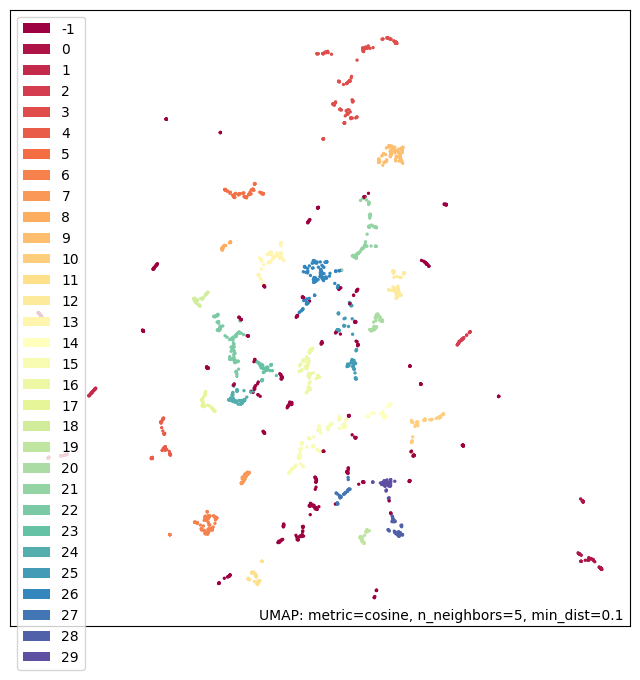

In [21]:
## https://umap-learn.readthedocs.io/en/latest/document_embedding.html
# uv pip install matplotlib pandas datashader bokeh holoviews
import umap.plot

ax=umap.plot.points(umap_mapper, labels=clusters.labels_)

In [22]:
# So : Can go through the clusters, and find the highest-probability tactic in each one...
#   Noise 'cluster' is a bit different, though
annotations_txy=[]
for cluster_label in range(n_clusters):
  best_example, best_score, cluster_count = None, -1, 0
  for idx_example, label in enumerate(clusters.labels_):
    if label!=cluster_label: continue
    score = clusters.probabilities_[idx_example]
    cluster_count += 1
    #print(f"{score:4f} vs {best_score:.4f}")
    if best_score<score:
      best_example, best_score = idx_example, score
  print(f"{cluster_label} : count={cluster_count:d}")  # , score={best_score:.4f} - always 1 for best
  for k,v in tactic_arr[best_example].items():
    print(f"  {k}: {v}")
  umap_coord = umap_mapper.embedding_[best_example, :]
  annotations_txy.append([ tactic_arr[best_example]['heading'], umap_coord[0], umap_coord[1] ] )

0 : count=70
  heading: Object Segmentation
  description: Divide the input grid into distinct objects based on properties like color and connectivity.
  dsl_functions: ['as_objects', 'partition']
1 : count=54
  heading: Subgrid Extraction
  description: Extract the smallest subgrid that encloses a specific object or region of interest.
  dsl_functions: ['smallest_subgrid_containing']
2 : count=32
  heading: Horizontal/Vertical Splitting
  description: Split the grid horizontally or vertically into subgrids to isolate features or patterns.
  dsl_functions: ['left_half', 'right_half', 'top_half', 'bottom_half', 'horizontal_split', 'vertical_split']
3 : count=171
  heading: Object Identification
  description: Identify distinct objects within the input grid based on color and connectivity.
  dsl_functions: ['as_objects']
4 : count=70
  heading: Grid Filling
  description: Fill cells of a grid with a given color based on a specified criteria (e.g., using index set).
  dsl_functions: ['fil

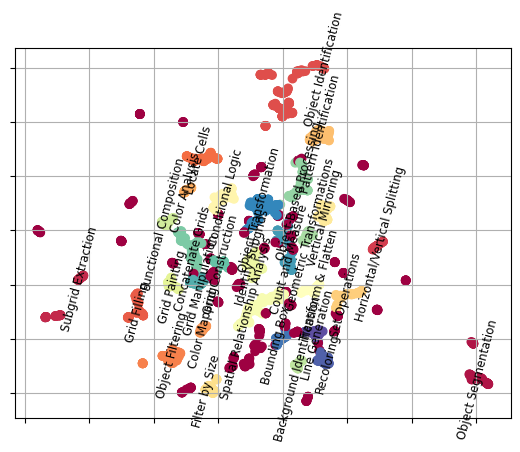

In [23]:
## https://umap-learn.readthedocs.io/en/latest/clustering.html

embeddings = umap_mapper.embedding_ 
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters.labels_, cmap='Spectral') # s=0.1 = marker size
plt.grid(True)

for a in annotations_txy: # This just the 'best' examples found above
  plt.annotate(a[0], (a[1], a[2]),  # (txt, (x[i], y[i])) 
               rotation=75, horizontalalignment='center', verticalalignment='center', 
               fontsize='small', 
               #backgroundcolor='white', zorder=-1  # , alpha=0.5
              )

frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])
plt.show()
# Hmm : https://stackoverflow.com/questions/19073683/how-to-fix-overlapping-annotations-text

In [24]:
#   Noise 'cluster' is a bit different, though
noise_count=0
for idx_example, label in enumerate(clusters.labels_):
  if label!=-1: continue
  score = clusters.probabilities_[idx_example]
  noise_count+=1
  #print(f"{score:4f} vs {best_score:.4f}")
  #if best_score<score:
  #  best_example, best_score = idx_example, score
  print(f"Noise sample : ")  # score={score:.4f} - always zero for noise 
  for k,v in tactic_arr[idx_example].items():
    print(f"  {k}: {v}")
print(f"\nNoise count={noise_count:d}")

Noise sample : 
  heading: Upscale Grid
  description: Increase the size of the grid in one or both dimensions.
  dsl_functions: ['horizontal_upscale', 'vertical_upscale', 'upscale']
Noise sample : 
  heading: Cellwise Operation
  description: Compare corresponding cells of two grids and apply a rule based on the comparison.
  dsl_functions: ['cellwise']
Noise sample : 
  heading: Repeat Pattern
  description: Reproduce a specific pattern or section of the grid multiple times.
  dsl_functions: ['repeat']
Noise sample : 
  heading: Fill Background
  description: Fill empty parts of the grid with a specific color.
  dsl_functions: ['fill_background']
Noise sample : 
  heading: Split and Concatenate
  description: Divide the input grid into subgrids, process them independently, and combine the results.
  dsl_functions: ['top_half', 'bottom_half', 'vertical_concat', 'horizontal_concat', 'horizontal_split', 'vertical_split']
Noise sample : 
  heading: Property Extraction
  description: Extr

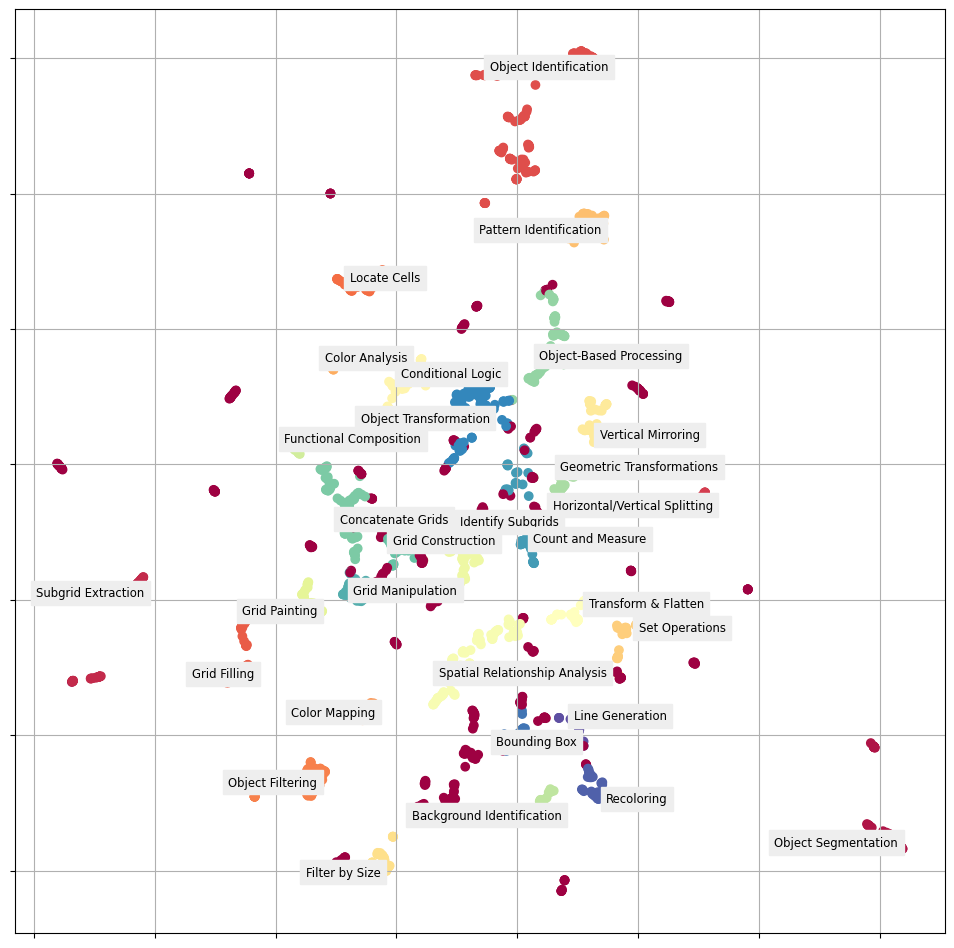

In [30]:
# Hmm : https://stackoverflow.com/questions/19073683/how-to-fix-overlapping-annotations-text
## https://python-graph-gallery.com/web-text-repel-with-matplotlib/
# pip install adjustText
import adjustText

embeddings = umap_mapper.embedding_ 

plt.subplots(figsize=(12, 12),) #facecolor='lightskyblue', layout='constrained')

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters.labels_, cmap='Spectral') # s=0.1 = marker size
plt.grid(True)

GREY50="#7F7F7F"
annotations_adj = []
for a in annotations_txy: # This just the 'best' examples found above
  annotations_adj.append( plt.text(a[1], a[2], a[0], fontsize='small', ha='center', va='center',
                          backgroundcolor='#eeeeee', 
                          #zorder=-1  # , alpha=0.5
                        ) )
frame = plt.gca()
frame.axes.xaxis.set_ticklabels([])
frame.axes.yaxis.set_ticklabels([])
adjustText.adjust_text(
    annotations_adj, 
    #expand_points=(2, 2),
    arrowprops=dict(arrowstyle="->", color=GREY50, lw=1),
    ax=frame.axes
)    
plt.show()